## To Do
- [DONE] work with messages
- [DONE] compare messages sent vs received
- [DONE-ish] switch from df.plot -> seaborn
- [TOO LONG] do the river flow chart?
- try to combine line plot and heatmap (overlaid) + replace passes/likes by total AND add messages ?
- finalize what I want to viz -> MAX 4 viz (includes triple heatmap)

## Custom functions

In [158]:
def replace_zeros_inf(df):
    df.fillna(0, inplace=True)
    df = df.replace([np.inf, -np.inf], 0)
    return df

def mask_max_min_vals(df, col):
    top_n_values = df[col].nlargest(1)
    bot_n_values = df[col].nsmallest(1)
    mask = df[col].apply(lambda x: x if x in top_n_values.values or x in bot_n_values.values else "")
    return mask.to_frame().T

def mask_top_n_vals(df, col, n):
    top_n_values = df[col].nlargest(n)
    mask = df[col].apply(lambda x: x if x in top_n_values.values else "")
    return mask.to_frame().T

def scale(df, cols):
    for col in cols:
        df[col] = (df[col]-df[col].mean()) /(df[col].max()-df[col].min())   
    return df

# Reading data

In [159]:
import numpy as np
import pandas as pd
import seaborn as sns
import json
import matplotlib.pyplot as plt
# from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.colors import ListedColormap
plt.close("all")

In [160]:
#Ref: https://medium.com/analytics-vidhya/tinder-data-54ba494e0a59
f = open('Data/myData/data_usage.json', 'r', encoding="utf8")
data = json.load(f)

df = pd.DataFrame.from_dict(data)
# print(df)
max_row = df.loc[df['swipes_passes'].idxmax()]
print(max_row)
df.describe()

app_opens              16
swipes_likes           10
swipes_passes        1152
superlikes              0
matches                 0
messages_sent           0
messages_received       0
advertising_id           
idfa                     
Name: 2023-03-03, dtype: object


,app_opens,swipes_likes,swipes_passes,superlikes,matches,messages_sent,messages_received
count,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000,192.000000
mean,7.354167,1.833333,80.677083,0.010417,0.552083,1.786458,1.822917
std,6.467768,2.862162,137.262503,0.101795,0.829682,5.634711,6.507337
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,0.000000,17.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.000000,38.000000,0.000000,0.000000,0.000000,0.000000
75%,10.000000,2.000000,82.250000,0.000000,1.000000,2.000000,1.000000
max,40.000000,15.000000,1152.000000,1.000000,5.000000,64.000000,79.000000


# Wrangling

In [161]:
df.index.name = "Date"
df = df.sort_values(["swipes_passes"], ascending = False)
if "superlikes" in df.columns:
    df = df.drop(["superlikes", "advertising_id", "idfa"], axis = 1)
    
    
df.index = pd.to_datetime(df.index)
df = df.sort_values(by='Date')


#fill in missing dates
all_dates = pd.date_range(start='2022-11-19', end='2023-09-22', freq='D')
df = df.reindex(all_dates, fill_value=0)

df["swipes_likes_no_match"] = df["swipes_likes"] - df["matches"]
df["matches_cumsum"] = df["matches"].cumsum()
df["likes_cumsum"] = df["swipes_likes"].cumsum()
df["passes_cumsum"] = df["swipes_passes"].cumsum()
df = replace_zeros_inf(df)

TO_B_SCALED = ["swipes_likes", "swipes_passes", "matches", "swipes_likes_no_match", "messages_sent", "messages_received"]
#WEEKLY STATS
weekly = df.resample("W-MON").sum()
weekly["matches_cumsum"] = weekly["matches"].cumsum()
weekly["likes_cumsum"] = weekly["swipes_likes"].cumsum()
weekly["passes_cumsum"] = weekly["swipes_passes"].cumsum()

weekly["matches_like_pct"] = 100*weekly["matches"] / weekly["swipes_likes"] 
weekly = replace_zeros_inf(weekly)

weekly['DayOfWeek'] = weekly.index.day_name()
weekly['Month'] = weekly.index.month

weekly_scaled = weekly.copy()
scale(weekly_scaled, TO_B_SCALED)

#MONTHLY STATS
monthly = df.resample("MS").sum()
monthly["matches_cumsum"] = monthly["matches"].cumsum()
monthly["likes_cumsum"] = monthly["swipes_likes"].cumsum()
monthly["passes_cumsum"] = monthly["swipes_passes"].cumsum()

monthly["matches_like_pct"] = 100 * monthly["matches"] / monthly["swipes_likes"]
monthly = replace_zeros_inf(monthly)

monthly['DayOfWeek'] = monthly.index.day_name()
monthly['Month'] = monthly.index.month

monthly_scaled = monthly.copy()
scale(monthly_scaled, TO_B_SCALED)


# monthly_scaled = monthly_scaled.drop(monthly_scaled.index[0])
# monthly_scaled = monthly_scaled.drop("matches_cumsum")

# nb_passes_matches = (monthly_scaled["swipes_likes"]  + monthly_scaled["swipes_passes"] )

# monthly_scaled["swipes_passes"] = 100*monthly_scaled["swipes_passes"] / nb_passes_matches
# monthly_scaled["swipes_likes_no_match"] = 100*monthly_scaled["swipes_likes_no_match"] / nb_passes_matches
# monthly_scaled["matches"] = 100*monthly_scaled["matches"] / nb_passes_matches

# df_likes_matches_monthly_scaled = weekly.resample("MS").sum()

# nb_likes_matches = (df_likes_matches_monthly_scaled["matches"] + df_likes_matches_monthly_scaled["swipes_likes"])

# df_likes_matches_monthly_scaled["swipes_likes"] = 100*df_likes_matches_monthly_scaled["swipes_likes"] / nb_likes_matches
# df_likes_matches_monthly_scaled["matches"] = 100*df_likes_matches_monthly_scaled["matches"] / nb_likes_matches


# df.head(100)
# weekly.head()
# df = df.describe()
print(monthly)
print(monthly.columns)


            app_opens  swipes_likes  swipes_passes  matches  messages_sent  \
2022-11-01         83            23           1282        4              2   
2022-12-01        177            43           1591       19            109   
2023-01-01        146            37            954       10             35   
2023-02-01        157            33           2078       11             11   
2023-03-01        194            39           2209       11             40   
2023-04-01        232            55           1710       16             74   
2023-05-01        110            49           1377       10             18   
2023-06-01         19            13            754        5              3   
2023-07-01         23            18            975        3              0   
2023-08-01        101            28           1064       11             28   
2023-09-01        170            14           1496        6             23   

            messages_received  swipes_likes_no_match  matches_c

# Visualization

### Line plots

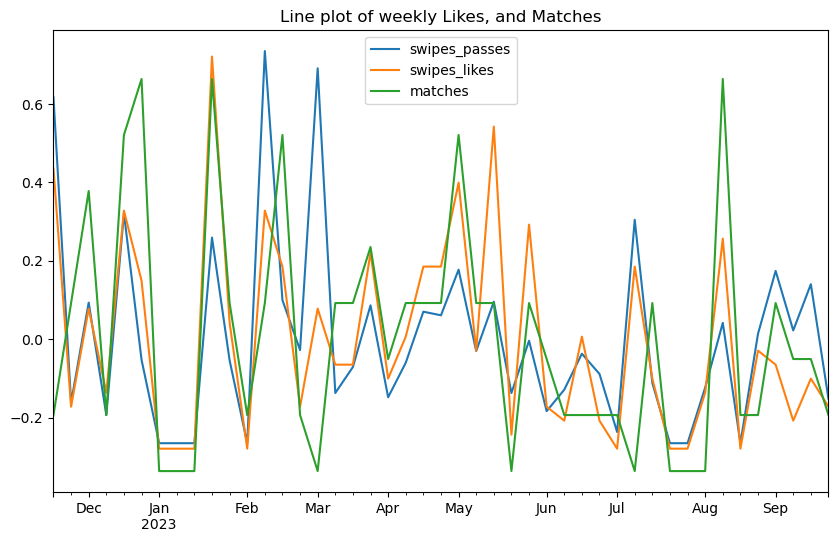

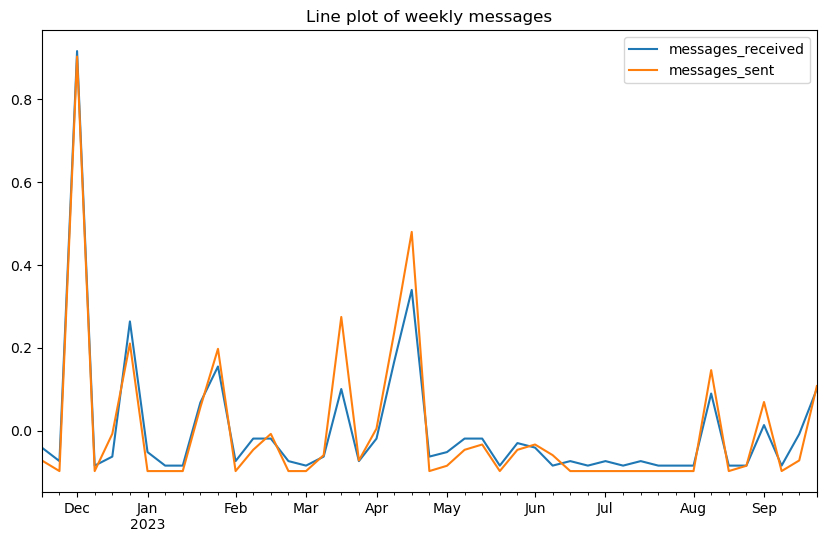

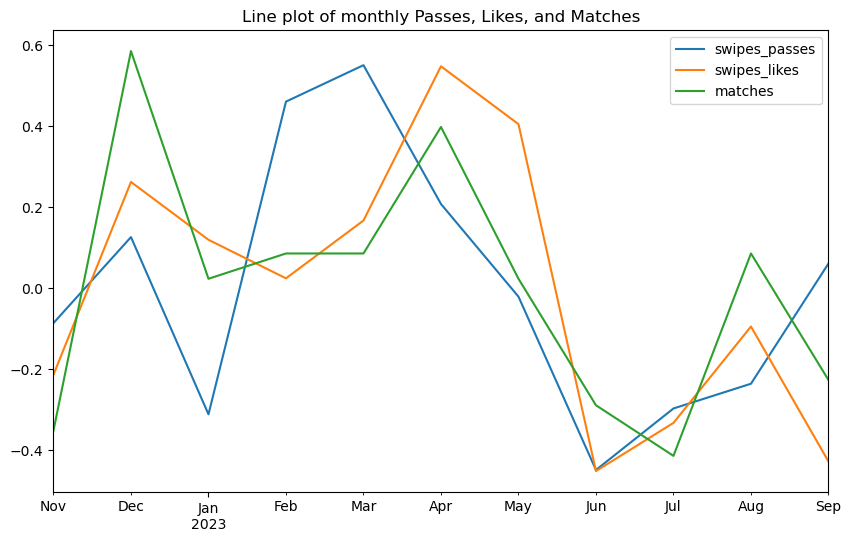

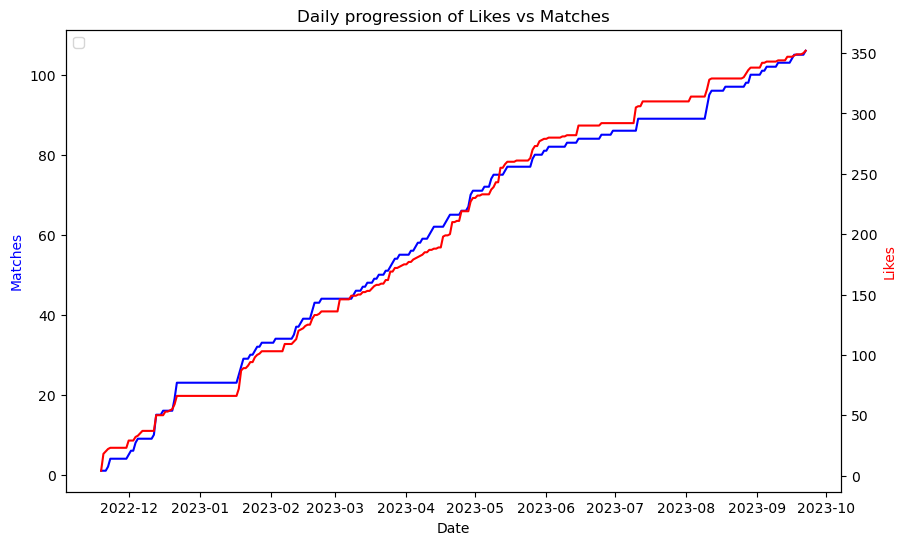

<Axes: title={'center': 'match pct per month'}>

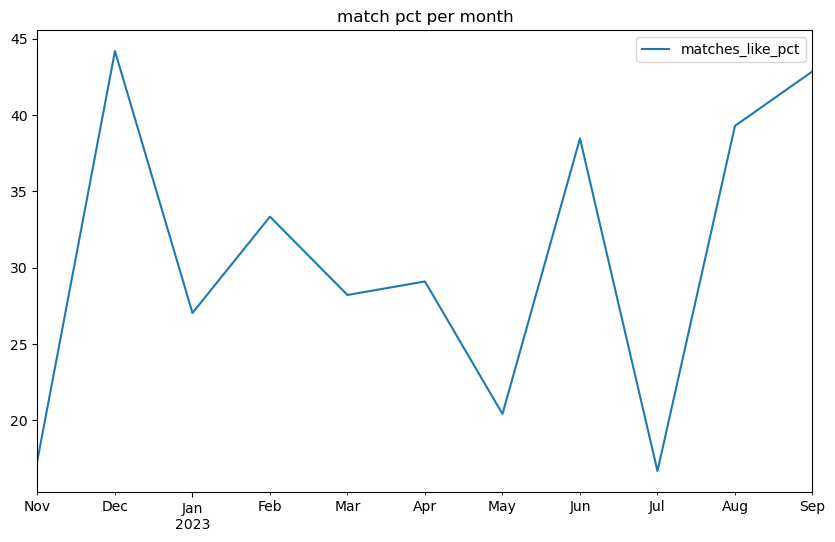

In [162]:
#Weekly Passes, Likes, and Matches
plt.figure(figsize=(10, 6))
ax = plt.gca()
weekly_scaled.plot(y = "swipes_passes", figsize=(10, 6), ax = ax)
weekly_scaled.plot(y = "swipes_likes", figsize=(10, 6), ax = ax, title = "Line plot of weekly Likes, and Matches")
weekly_scaled.plot(y = "matches", figsize=(10, 6), ax = ax)
plt.show()


#Weekly Messages
plt.figure(figsize=(10, 6))
ax = plt.gca()
# weekly_scaled.plot(y = "swipes_passes", figsize=(10, 6), ax = ax)
weekly_scaled.plot(y = "messages_received", figsize=(10, 6), ax = ax, title = "Line plot of weekly messages")
weekly_scaled.plot(y = "messages_sent", figsize=(10, 6), ax = ax)
plt.show()

#Monthly Passes, Likes, and Matches
plt.figure(figsize=(10, 6))
ax = plt.gca()
monthly_scaled.plot(y = "swipes_passes", figsize=(10, 6), ax = ax, title = "Line plot of monthly Passes, Likes, and Matches")
monthly_scaled.plot(y = "swipes_likes", figsize=(10, 6), ax = ax)
monthly_scaled.plot(y = "matches", figsize=(10, 6), ax = ax)
plt.show()

# plt.figure(figsize=(10, 6))
# ax = plt.gca()
# df.plot(y = "swipes_passes", ax = ax)
# df.plot(y = "swipes_likes", ax = ax)
# plt.show()

#passes per day
# df.plot(y = "swipes_passes", figsize=(10, 6), title = "passes per day")

#likes per day
# df.plot(y = "swipes_likes", figsize=(10, 6), title = "likes per day")
#matches per day
# df.plot(y = "matches", figsize=(10, 6), title = "matches per day") #bad

#matches daily progression
fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(df.index, df["matches_cumsum"], color = "blue") 
ax2 = ax1.twinx()
ax2.plot(df.index, df["likes_cumsum"], color = "red") 

ax1.set_xlabel('Date')
ax1.set_ylabel('Matches', color='blue')
ax2.set_ylabel('Likes', color='red')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2, loc='upper left')

plt.title("Daily progression of Likes vs Matches")
plt.show()

#passes per weeks
# weekly.plot(y = "swipes_likes", figsize=(10, 6), title = "passes per weeks")

#match pct weeks
# weekly_bis = weekly.filter(weekly["matches"] != 0)
# weekly.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per week")

#match pct month
monthly_scaled.plot(y = "matches_like_pct", figsize=(10, 6), title = "match pct per month")

### Scatter plots

array([[<Axes: xlabel='app_opens', ylabel='app_opens'>,
        <Axes: xlabel='swipes_likes', ylabel='app_opens'>,
        <Axes: xlabel='swipes_passes', ylabel='app_opens'>,
        <Axes: xlabel='matches', ylabel='app_opens'>,
        <Axes: xlabel='messages_sent', ylabel='app_opens'>,
        <Axes: xlabel='messages_received', ylabel='app_opens'>,
        <Axes: xlabel='swipes_likes_no_match', ylabel='app_opens'>,
        <Axes: xlabel='matches_cumsum', ylabel='app_opens'>,
        <Axes: xlabel='likes_cumsum', ylabel='app_opens'>,
        <Axes: xlabel='passes_cumsum', ylabel='app_opens'>],
       [<Axes: xlabel='app_opens', ylabel='swipes_likes'>,
        <Axes: xlabel='swipes_likes', ylabel='swipes_likes'>,
        <Axes: xlabel='swipes_passes', ylabel='swipes_likes'>,
        <Axes: xlabel='matches', ylabel='swipes_likes'>,
        <Axes: xlabel='messages_sent', ylabel='swipes_likes'>,
        <Axes: xlabel='messages_received', ylabel='swipes_likes'>,
        <Axes: xlabel='swip

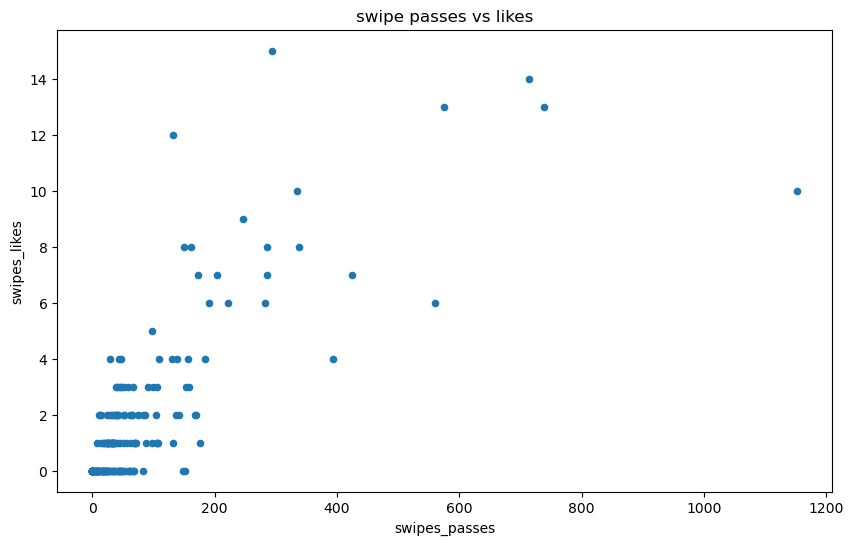

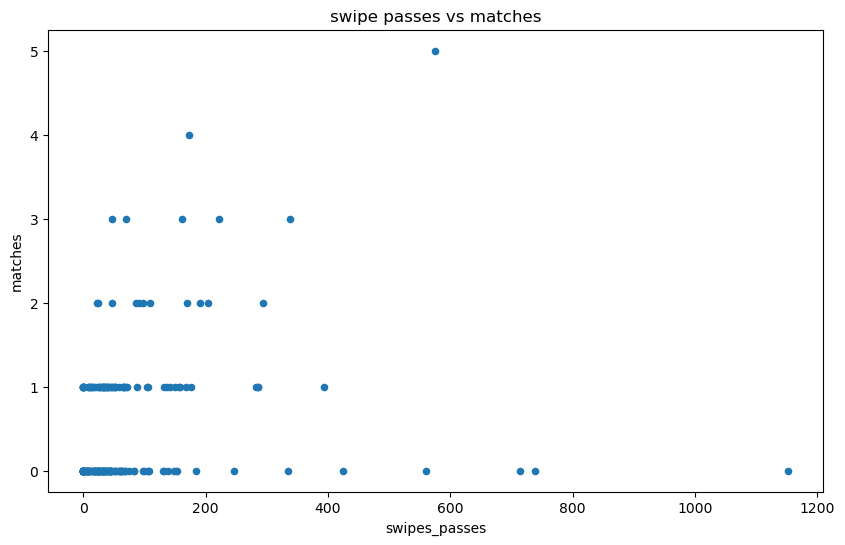

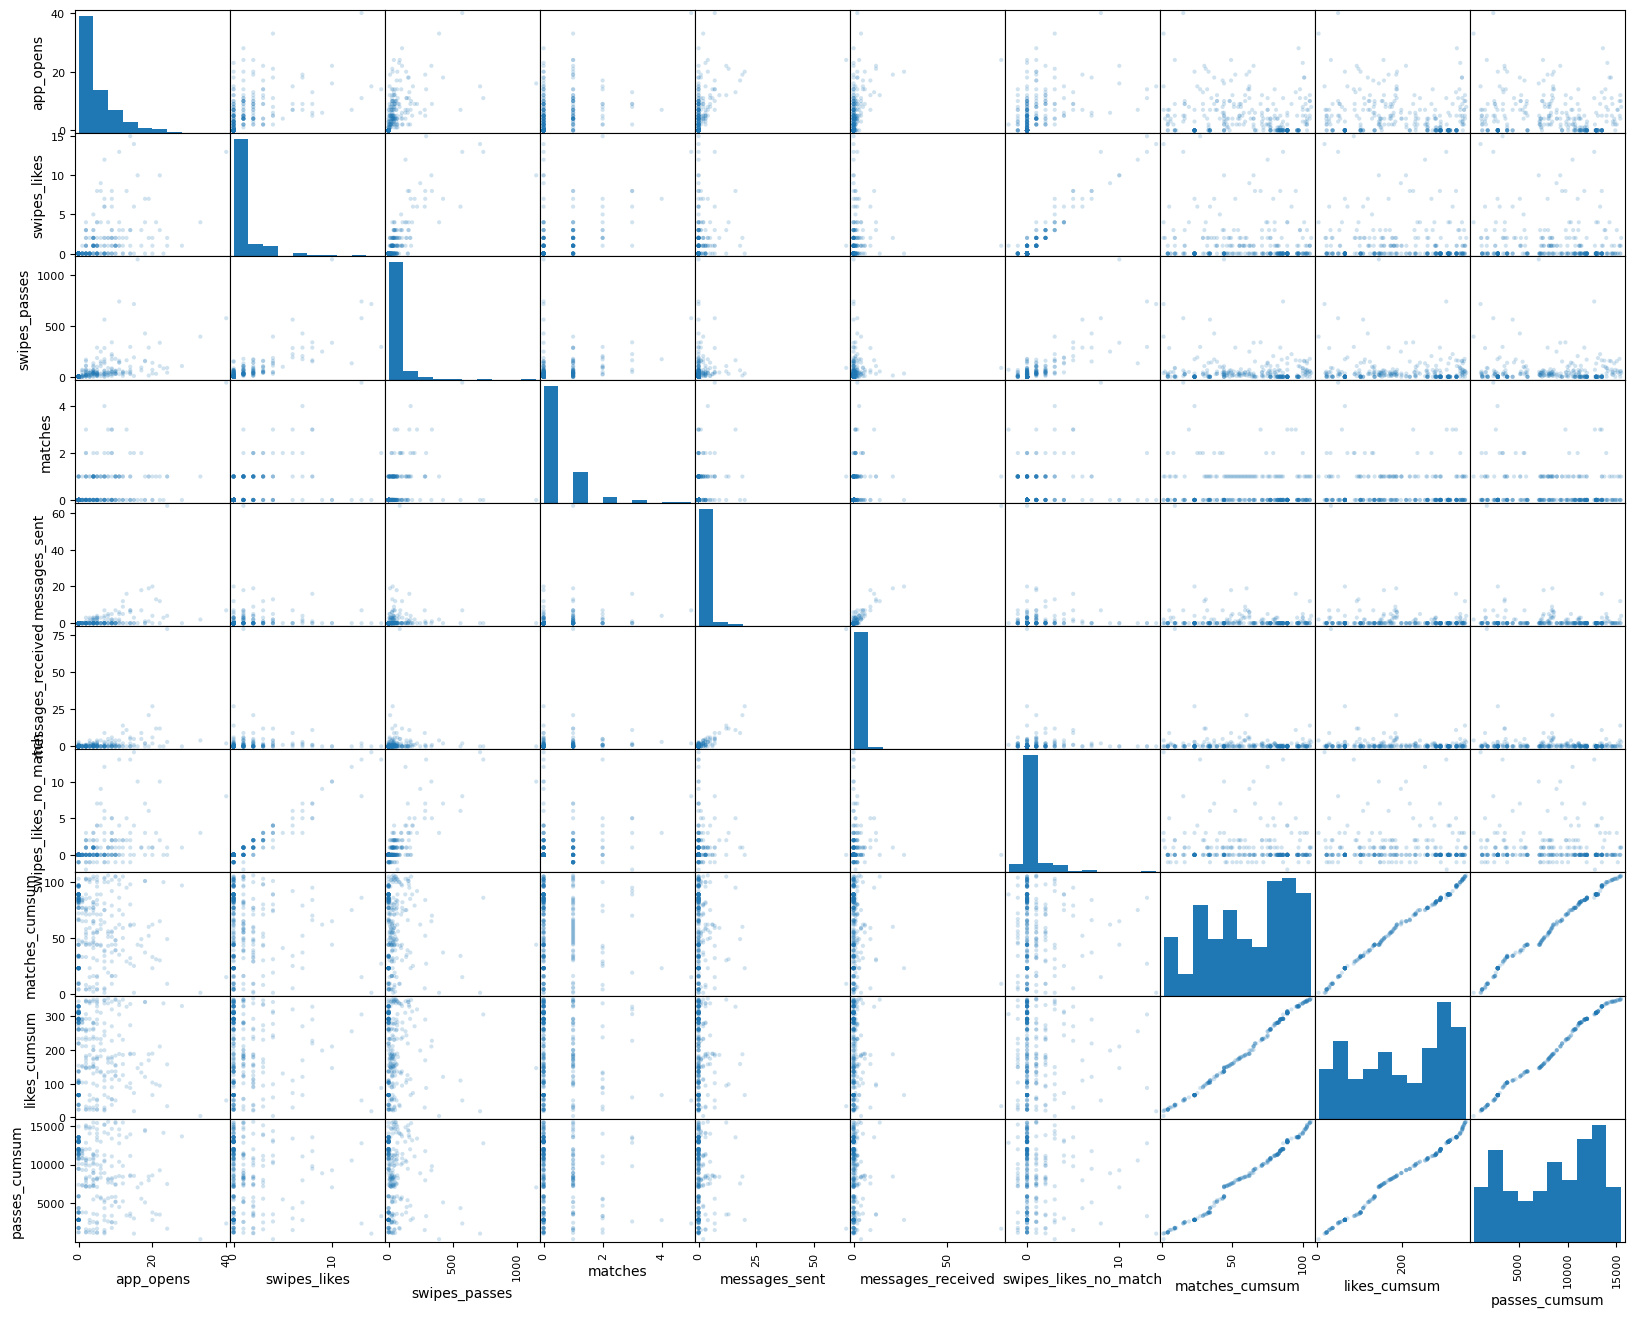

In [163]:
#swipe passes vs swipe likes
df.plot.scatter(x = "swipes_passes", y = "swipes_likes", figsize=(10, 6), title = "swipe passes vs likes") #bad
#swipe passes vs matches
df.plot.scatter(x = "swipes_passes", y = "matches", figsize=(10, 6), title = "swipe passes vs matches") 
pd.plotting.scatter_matrix(df, alpha = .2, figsize=(20, 16))

### Histograms

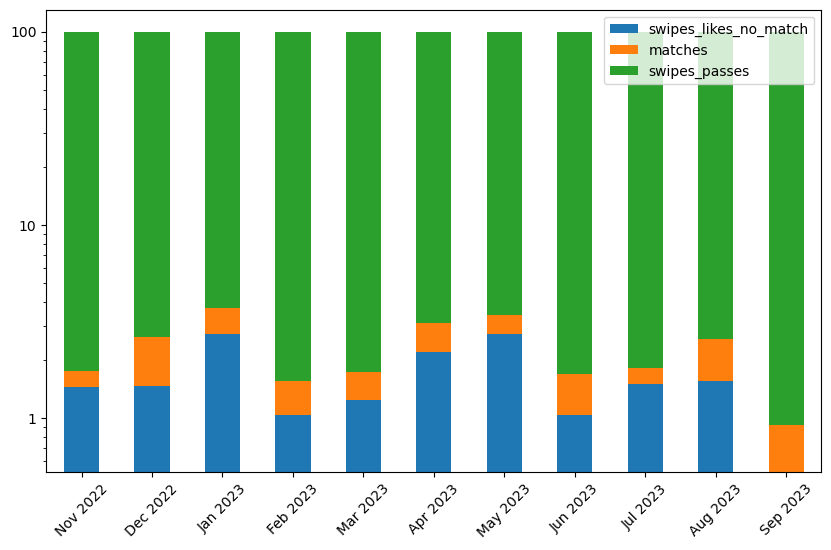

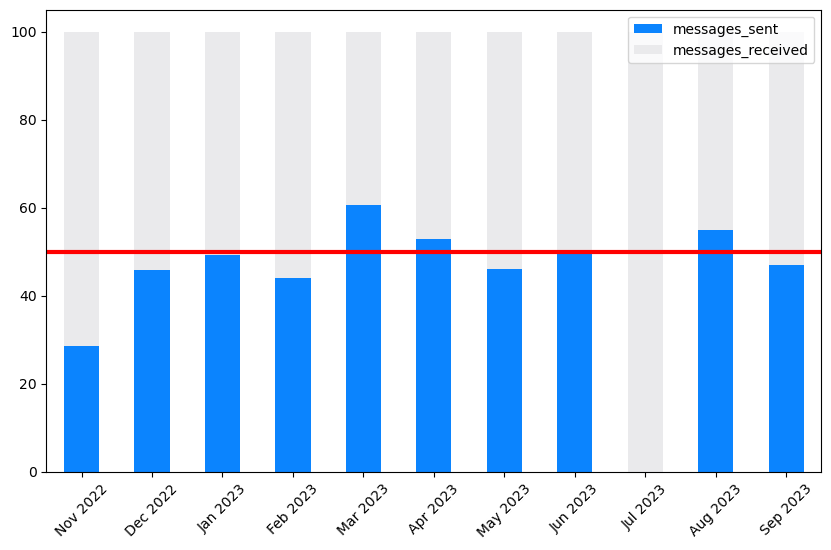

In [164]:
# #weekly passes + matches bar
# fig, ax1 = plt.subplots(figsize = (10,6))
# # sns.barplot(weekly_scaled, x = weekly_scaled.index, y = ["swipes_likes_no_match", "matches", "swipes_passes"], ax = ax1)
# ax2 = ax1.twinx()
# sns.lineplot(weekly_scaled, x = weekly_scaled.index, y = ["swipes_likes_no_match", "matches", "swipes_passes"], ax = ax2)
# plt.show()

#monthly likes + matches bar scaled to 100 AKA success rate
# monthly.plot.bar(y = ["matches"], stacked = True, figsize=(20,10))

#Monthly like, pass, match percentage comparaison

sum_plm = monthly["swipes_likes"] + monthly["swipes_passes"]
monthly_pct = monthly.copy()
monthly_pct["swipes_likes_no_match"] = 100 * monthly_pct["swipes_likes_no_match"] / sum_plm
monthly_pct["matches"] = 100 * monthly_pct["matches"] / sum_plm
monthly_pct["swipes_passes"] = 100 * monthly_pct["swipes_passes"] / sum_plm

monthly_pct.plot.bar(y = ["swipes_likes_no_match", "matches", "swipes_passes"], stacked = True, figsize=(10, 6))

date_format = '%b %Y'  # Customize the date format
x_ticks = range(len(monthly_pct.index))
formatted_labels = [date.strftime(date_format) for date in monthly_pct.index]
plt.xticks(x_ticks, formatted_labels, rotation=45)
plt.yscale("log")
y_ticks = [1, 10, 100]  # Custom y-axis ticks (integers)
y_tick_labels = [str(y) for y in y_ticks]  # Convert to string for labeling
plt.yticks(y_ticks, y_tick_labels)  # Set custom y-axis ticks and labels
# 


#Monthly messages received vs sent

sum_mess = monthly["messages_sent"] + monthly["messages_received"]
monthly_pct_mess = monthly.copy()
monthly_pct_mess["messages_sent"] = 100 * monthly_pct_mess["messages_sent"] / sum_mess
monthly_pct_mess["messages_received"] = 100 * monthly_pct_mess["messages_received"] / sum_mess

monthly_pct_mess.plot.bar(y = ["messages_sent", "messages_received"], color = ["#0B84FE", "#EAEAEC"], stacked = True, figsize=(10, 6))

date_format = '%b %Y'  # Customize the date format
x_ticks = range(len(monthly_pct.index))
formatted_labels = [date.strftime(date_format) for date in monthly_pct.index]
plt.xticks(x_ticks, formatted_labels, rotation=45)
plt.axhline(y = 50, color = "red", linestyle = "-", linewidth = 3, label = 'Y = 50')

### 1D Heatmap

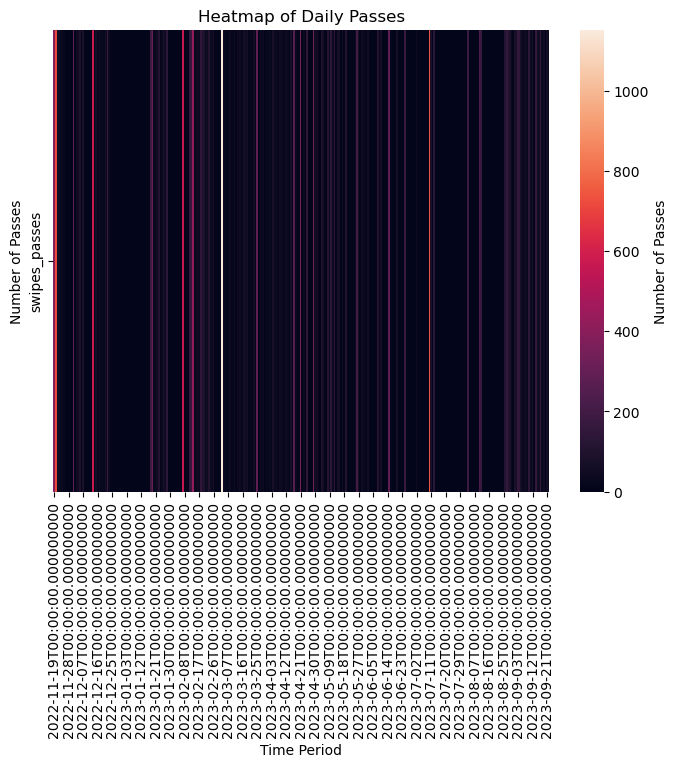

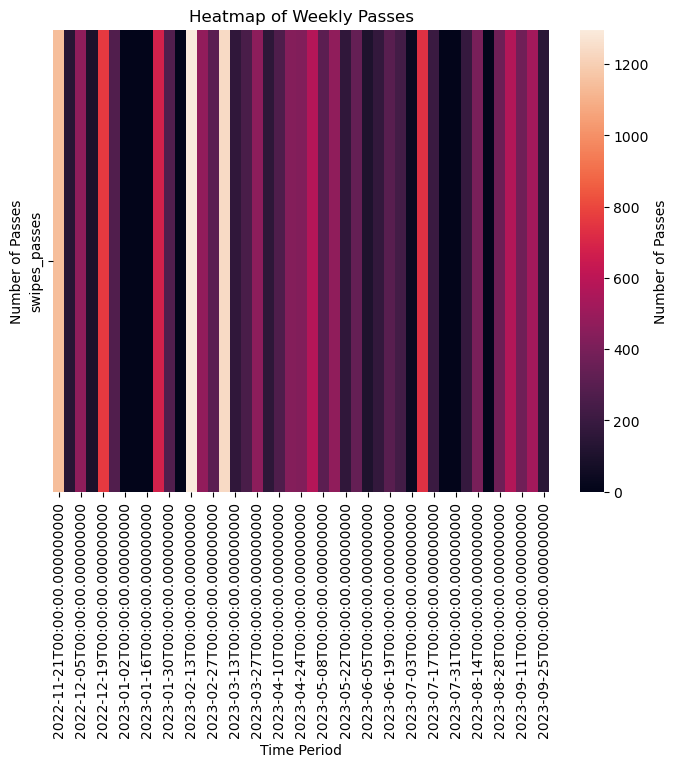

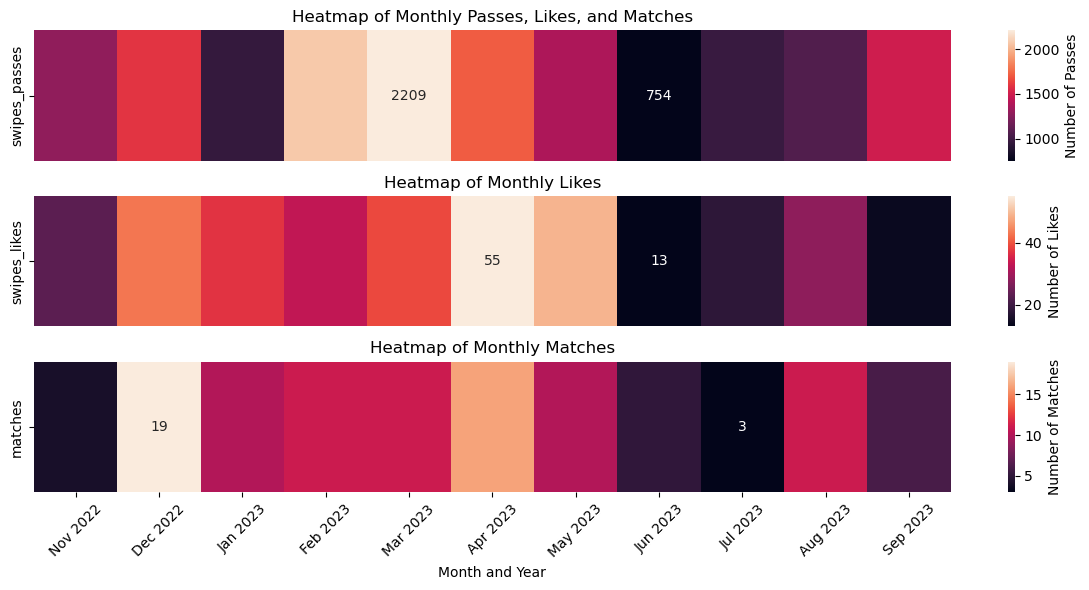

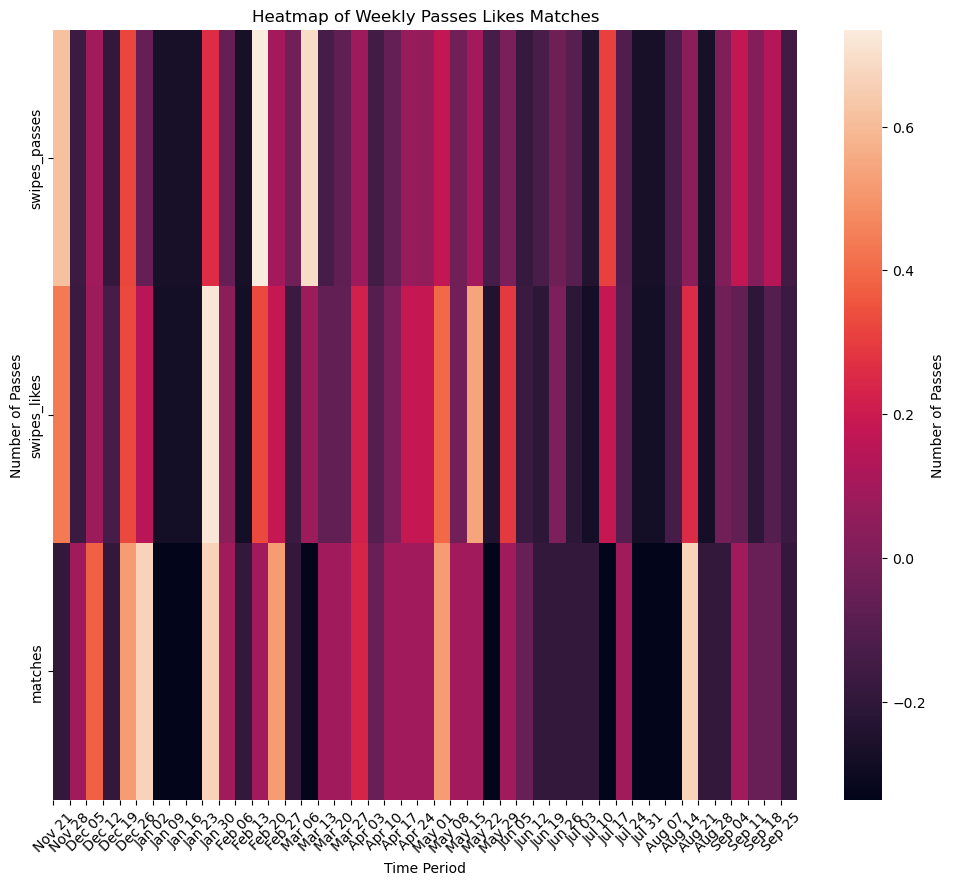

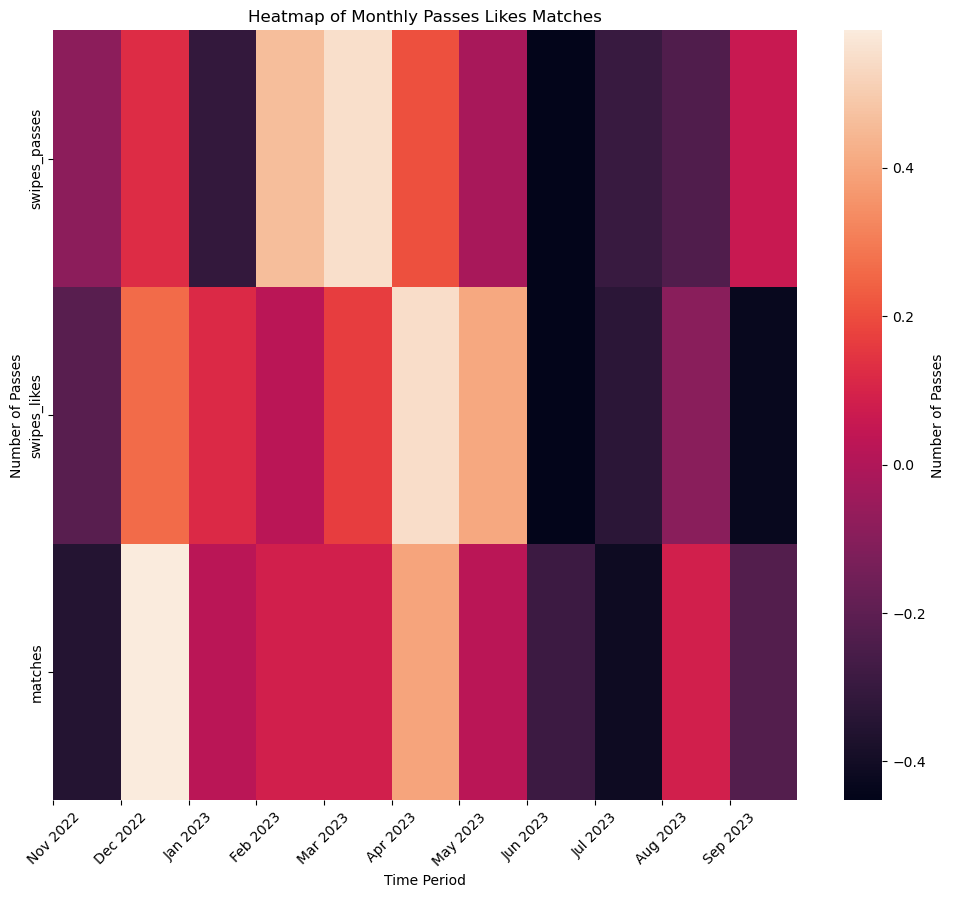

In [165]:


#passes heatmap daily

plt.figure(figsize=(8, 6))
sns.heatmap(df[["swipes_passes"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Daily Passes')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')
plt.show()



#passes heatmap weekly

plt.figure(figsize=(8, 6))
sns.heatmap(weekly[["swipes_passes"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Weekly Passes')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')
plt.show()

# 3 subplots likes passes matches heatmap monthly

fig, axes = plt.subplots(3, 1, figsize=(12, 6))
plt.tick_params(bottom='on')

sns.heatmap(monthly[["swipes_passes"]].T, ax = axes[0], annot=mask_max_min_vals(monthly, "swipes_passes"), fmt='', cbar_kws={'label': 'Number of Passes'})
# ax2 = axes[0].twinx()
# ax2.plot(monthly.index, monthly['swipes_passes'], color='red', linewidth=5, label='Line Plot')
# sns.lineplot(data=monthly, x=monthly.index, y='swipes_passes', ax=ax2, color='red')

# ax2.legend()
sns.heatmap(monthly[["swipes_likes"]].T, ax = axes[1], annot=mask_max_min_vals(monthly, "swipes_likes"), fmt='', cbar_kws={'label': 'Number of Likes'})
sns.heatmap(monthly[["matches"]].T, ax = axes[2], annot=mask_max_min_vals(monthly, "matches"), fmt='', cbar_kws={'label': 'Number of Matches'})

sns.color_palette("rocket", as_cmap=True)

axes[0].xaxis.set_visible(False)
axes[1].xaxis.set_visible(False)

axes[0].set_title('Heatmap of Monthly Passes, Likes, and Matches')
axes[1].set_title('Heatmap of Monthly Likes')
axes[2].set_title('Heatmap of Monthly Matches')

# axes[2].xaxis.set_major_locator(MonthLocator(interval=1))
# axes[2].xaxis.set_major_formatter(DateFormatter('%b'))
date_format = monthly.index.strftime('%b %Y')
axes[2].set_xticklabels(date_format, rotation=45)


plt.xlabel('Month and Year')
plt.xticks(rotation=45)
# plt.ylabel('Number of Passes')
plt.tight_layout()
plt.show()


#3 variable heatmap scaled weekly

plt.figure(figsize=(12, 10))
sns.heatmap(weekly_scaled[["swipes_passes", "swipes_likes", "matches"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Weekly Passes Likes Matches')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')

date_format = '%b %d'  # Customize the date format
x_ticks = range(len(weekly_scaled.index))
formatted_labels = [date.strftime(date_format) for date in weekly_scaled.index]
plt.xticks(x_ticks, formatted_labels, rotation=45)

plt.show()


#3 variable heatmap scaled monthly

plt.figure(figsize=(12, 10))
sns.heatmap(monthly_scaled[["swipes_passes", "swipes_likes", "matches"]].T, annot=False, fmt='d', cbar_kws={'label': 'Number of Passes'})
sns.color_palette("rocket", as_cmap=True)
plt.title('Heatmap of Monthly Passes Likes Matches')
plt.xlabel('Time Period')
plt.ylabel('Number of Passes')

date_format = '%b %Y'  # Customize the date format
x_ticks = range(len(monthly_scaled.index))
formatted_labels = [date.strftime(date_format) for date in monthly_scaled.index]
plt.xticks(x_ticks, formatted_labels, rotation=45)

plt.show()

### 2D Heatmap

['2022 11', '2022 12', '2023 1', '2023 2', '2023 3', '2023 4', '2023 5', '2023 6', '2023 7', '2023 8', '2023 9']


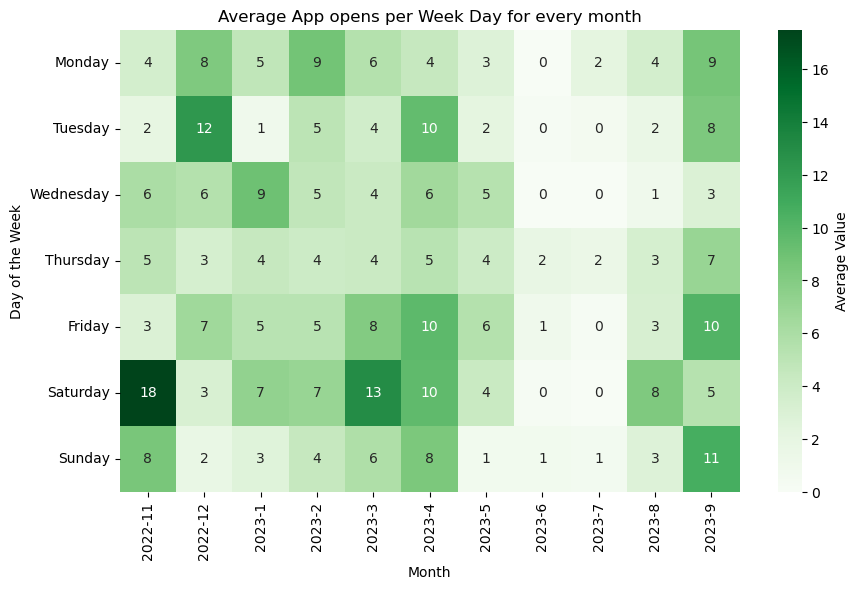

Year        2022                 2023                                 \
Month         11         12        1         2          3         4    
count   7.000000   7.000000  7.000000  7.000000   7.000000  7.000000   
mean    6.500000   5.850000  4.914286  5.607143   6.342857  7.642857   
std     5.307228   3.587943  2.680907  1.676163   3.266806  2.206133   
min     2.000000   1.750000  1.000000  4.000000   3.750000  4.500000   
25%     3.250000   3.300000  3.550000  4.625000   4.200000  5.875000   
50%     5.000000   5.500000  4.800000  5.000000   5.500000  8.400000   
75%     7.250000   7.425000  6.250000  6.125000   6.875000  9.550000   
max    17.500000  12.250000  9.000000  8.750000  13.000000  9.750000   

Year                                                      
Month        5         6         7         8          9   
count  7.000000  7.000000  7.000000  7.000000   7.000000  
mean   3.557143  0.578571  0.721429  3.392857   7.607143  
std    1.738876  0.656288  0.828582  2.344396   2.731298  
min    0.750000  0.000000  0.000000  1.000000   3.000000  
25%    2.500000  0.125000  0.125000  2.175000   6.166667  
50%    4.000000  0.250000  0.500000  3.250000   8.333333  
75%    4.825000  0.875000  1.050000  3.450000   9.458333  
max    5.500000  1.800000  2.200000  8.250000  10.666667

In [166]:
df['Month'] = df.index.month
df['Year'] = df.index.year
df['DayOfWeek'] = (df.index.day_name())
df["DayOfWeek"] = pd.Categorical(df["DayOfWeek"], categories=days_of_week_order, ordered=True)

# print(df)

# scale(df,"swipes_passes")

days_of_week_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
# Heatmap Avg Value

heatmap_data = df.pivot_table(index='DayOfWeek', columns=['Year','Month'], values='app_opens', aggfunc='mean')
x_labels = [f"{month} {year}" for month, year in heatmap_data.columns]
print(x_labels)

plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".0f", cbar_kws={'label': 'Average Value'}, cmap = "Greens", yticklabels=days_of_week_order)
plt.title('Average App opens per Week Day for every month')
plt.xlabel('Month')
plt.ylabel('Day of the Week')


# date_format = '%b %Y'  # Customize the date format
# x_ticks = range(len(heatmap_data.index))
# formatted_labels = [date.strftime(date_format) for date in heatmap_data.index]
# plt.xticks(x_ticks, formatted_labels, rotation=45)

plt.show()


# # Heatmap Sum Value
# heatmap_data = df.pivot_table(index='DayOfWeek', columns=['Month', 'Year'], values='swipes_passes', aggfunc='sum')
# plt.figure(figsize=(10, 6))
# sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap = "Greens", cbar_kws={'label': 'Sum Value'}, yticklabels=days_of_week_order)

# plt.title('Sum Passes per Week Day for every month')
# plt.xlabel('Month')
# plt.ylabel('Day of the Week')

# plt.show()
heatmap_data.describe()

## ChatGPT Testing

In [167]:
# import seaborn as sns
# import pandas as pd
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3]}
# df = pd.DataFrame(data)

# # Sort the values in the column and select the top 10
# top_n_values = df['swipes_passes'].nlargest(3)

# # Create a mask to annotate only the top 10 values
# mask = df['swipes_passes'].apply(lambda x: x if x in top_n_values.values else "")

# # Create a heatmap with the column as the y-variable
# plt.figure(figsize=(8, 6))
# sns.heatmap(df[['swipes_passes']].T, annot=mask.to_frame().T, fmt='', cmap='RdYlGn', cbar_kws={'label': 'Number of Passes'})
# plt.title('Heatmap of Top 10 Passes')
# plt.xlabel('Time Period')
# plt.ylabel('Number of Passes')
# plt.show()


# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3]}
# df = pd.DataFrame(data)

# # Calculate the mean of the column
# mean_value = df['swipes_passes'].mean()

# # Scale the data to have values from -1 to 1 with the mean as 0
# scaled_data = 2 * (df['swipes_passes'] - mean_value) / (df['swipes_passes'].max() - df['swipes_passes'].min())

# # Create a heatmap with the scaled column
# plt.figure(figsize=(8, 6))
# sns.heatmap(scaled_data.to_frame().T, annot=True, fmt='.2f', cmap='RdYlGn', cbar_kws={'label': 'Scaled Values'})
# plt.title('Heatmap with Values Scaled from -1 to 1 (Mean 0)')
# plt.xlabel('Time Period')
# plt.ylabel('Scaled Values')
# plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Sample data (replace this with your own data)
# data = {'swipes_passes': [2, 8, 9, 12, 2, 3],
#         'swipes_likes_no_match': [5, 10, 15, 20, 25, 30]}

# monthly = pd.DataFrame(data)

# fig, ax = plt.subplots(figsize=(12, 6))

# # Create a single heatmap for both columns
# sns.heatmap(monthly[['swipes_passes', 'swipes_likes_no_match']].T, ax=ax, annot=False, fmt='d', cbar_kws={'label': 'Value'})

# ax.set_title('Heatmap of Monthly Data')
# ax.set_xlabel('Time Period')
# ax.set_ylabel('Columns')

# plt.show()
# import pandas as pd
# import matplotlib.pyplot as plt
# from matplotlib.dates import MonthLocator, DateFormatter

# # Sample data with a datetime index
# data = {'Value': [10, 20, 15, 30]}
# dates = pd.date_range(start='2023-01-01', periods=4, freq='M')

# df = pd.DataFrame(data, index=dates)

# # Create a line plot
# fig, ax = plt.subplots(figsize=(8, 6))
# ax.plot(df.index, df['Value'])

# # Set the x-axis locator and formatter to display month and year names
# ax.xaxis.set_major_locator(MonthLocator(interval=1))  # Show every month
# ax.xaxis.set_major_formatter(DateFormatter('%b %Y'))

# plt.xlabel('Month and Year')
# plt.ylabel('Value')
# plt.title('Monthly Data')

# plt.xticks(rotation=45)  # Rotate x-axis labels for better readability

# plt.show()

# import seaborn as sns
# import matplotlib.pyplot as plt
# import numpy as np

# # Sample data
# data = {'Value': [1, 2, 3, 4, 5],
#         'HeatmapData': [10, 15, 8, 25, 20],
#         'LinePlotData': [5, 10, 12, 8, 15]}

# df = pd.DataFrame(data)

# # Create a figure and a single subplot
# fig, ax1 = plt.subplots(figsize=(8, 6))

# # Create a heatmap on the primary y-axis
# sns.heatmap(np.array([df['HeatmapData']]), ax=ax1, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Heatmap Value'})
# ax1.set_title('Heatmap')
# ax1.set_xlabel('X-axis Label')
# ax1.set_ylabel('Heatmap Y-axis Label')

# # Create a secondary y-axis for the line plot
# ax2 = ax1.twinx()

# # Create a line plot on the secondary y-axis
# sns.lineplot(data=df, x='Value', y='LinePlotData', ax=ax2, color='red', label='Line Plot')
# ax2.set_ylabel('Line Plot Y-axis Label')

# # Show the plot
# plt.show()

# import matplotlib.pyplot as plt

# # Create three separate plots
# x = [1, 2, 3, 4, 5]
# y1 = [10, 15, 8, 25, 20]
# y2 = [5, 10, 12, 8, 15]
# y3 = [30, 20, 10, 5, 2]

# plt.figure(figsize=(10, 6))

# # First plot
# plt.plot(x, y1, label='Plot 1', color='blue')

# # Second plot
# plt.plot(x, y2, label='Plot 2', color='red')

# # Third plot
# plt.plot(x, y3, label='Plot 3', color='green')

# # Add legend to differentiate the plots
# plt.legend()

# # Set a title
# plt.title('Combined Plots')

# # Show the plot
# plt.show()
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# data1 = np.random.random((10, 10))
# data2 = np.random.random((10))

# f, ax = plt.subplots(figsize=(11, 9))
# plt.tick_params(bottom='on')
# ax = sns.heatmap(data1, cmap=sns.color_palette("Greens", 5))
# ax2 = plt.twinx()
# sns.lineplot(data=data2, linewidth=5, ax=ax2)
# ax.axis('tight')

# plt.show()
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# data1 = np.random.random((10, 10))
# data2 = np.random.random((10))

# f, ax = plt.subplots(figsize=(11, 9))
# plt.tick_params(bottom='on')
# ax = sns.heatmap(data1, cmap=sns.color_palette("Greens", 5))
# ax2 = plt.twinx()
# sns.lineplot(data=data2, linewidth=5, ax=ax2)
# ax.axis('tight')

# plt.show()



# import seaborn as sns
# import matplotlib.pyplot as plt

# # Sample data
# data = {
#     'Date': ['2023-01-01', '2023-01-02', '2023-01-03', '2023-01-04', '2023-01-05'],
#     'swipes_passes': [10, 15, 8, 25, 20],
# }

# monthly = pd.DataFrame(data)

# # Create a figure and a single subplot
# fig, ax1 = plt.subplots(figsize=(8, 6))

# # Create a heatmap on the primary y-axis
# sns.heatmap(monthly[['swipes_passes']].T, ax=ax1, cmap='YlGnBu', annot=True, fmt='d', cbar_kws={'label': 'Heatmap Value'})
# ax1.set_title('Heatmap')
# ax1.set_xlabel('X-axis Label')
# ax1.set_ylabel('Heatmap Y-axis Label')

# # Create a secondary y-axis for the line plot
# ax2 = ax1.twinx()

# # Create a line plot on the secondary y-axis
# sns.lineplot(data=monthly, x='Date', y='swipes_passes', ax=ax2, color='red', label='Line Plot')
# ax2.set_ylabel('Line Plot Y-axis Label')

# # Add a legend to differentiate the heatmap and line plot
# ax1.get_legend().remove()  # Remove the heatmap legend
# ax2.legend()

# # Show the plot
# plt.show()
# months = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
# Extract month and day of the week from the index


# import seaborn as sns
# import matplotlib.pyplot as plt

# # Sample data for the heatmap
# data = {
#     "swipes_passes": [10, 20, 30, 40],
#     "swipes_likes": [5, 15, 25, 35],
#     "matches": [2, 8, 10, 15]
# }

# # Create a DataFrame
# monthly_scaled = pd.DataFrame(data, columns=["swipes_passes", "swipes_likes", "matches"])

# # Create a mask for annotation (True where you want to annotate, False elsewhere)
# mask = monthly_scaled > 20  # For example, annotate values greater than 20

# # Create the heatmap
# plt.figure(figsize=(8, 6))
# sns.heatmap(monthly_scaled[["swipes_passes", "swipes_likes", "matches"]].T, annot=True, fmt='d', cbar_kws={'label': 'Value'}, mask=~mask)

# # Customize the title and labels
# plt.title('Heatmap with Annotations')
# plt.xlabel('X-axis Labels')
# plt.ylabel('Y-axis Labels')

# # Show the plot
# plt.show()